In [1]:
# Step 1: Setup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Load dataset
df = pd.read_excel('../Books_Dataset.xlsx')

# Preview
df.head()


,USER_ID,BOOK_ID,TITLE,AUTHOR,GENRE,TAGS,SUMMARY,Rating,No. of people Rated,PUBLISHER,PUBLICATION_YEAR
0,62,B1,Stay,Thomas Gates,Thriller,"War, Comedy, Science, Drama",Time green notice indeed beyond bar leg.,3.3,1366,"Patterson, Robertson and Walker",2023
1,8,B2,Oil paper ready take agency minute,Ernest Myers,Thriller,"Crime, Friendship, War",Develop model data at. Bring less less detail ...,3.5,2466,Jones-Arellano,1995
2,45,B3,Offer again garden,Robert Singh,Adventure,"War, Drama, Love, Crime, Comedy",Test future campaign economy. Someone property...,1.2,3026,"Underwood, Mercer and Bennett",1990
3,29,B4,Article it popular,Samantha Lang,Sci-Fi,"Crime, Philosophy, Friendship, Horror, Drama",Yeah food food should bill.,2.7,1462,"Webster, Cruz and Smith",1990
4,34,B5,Drop like,Sean Shaw,Biography,"Crime, War, Adventure, Philosophy",There clear magazine among. Get either dinner ...,4.0,1273,"Wright, Johnson and Thomas",2011


In [2]:
# Step 2: Prepare data for collaborative filtering

# Keep only necessary columns
ratings_df = df[['USER_ID', 'BOOK_ID', 'Rating']]

# Train-test split
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)


Train size: (5600, 3)
Test size: (1400, 3)


In [3]:
# Step 3: Create user-item matrix
user_item_matrix = train_df.pivot_table(
    index='USER_ID', 
    columns='BOOK_ID', 
    values='Rating'
)

user_item_matrix.head()


BOOK_ID,B1,B10,B100,B1000,B1001,B1002,B1004,B1005,B1007,B1008,...,B989,B99,B990,B991,B992,B993,B994,B996,B998,B999
USER_ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Step 4: Compute user similarity
user_similarity = cosine_similarity(user_item_matrix.fillna(0))
user_similarity_df = pd.DataFrame(
    user_similarity, 
    index=user_item_matrix.index, 
    columns=user_item_matrix.index
)

user_similarity_df.head()


USER_ID,1,2,3,4,5,6,7,8,9,10,...,71,72,73,74,75,76,77,78,79,80
USER_ID,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Step 5: Predict ratings using weighted average of similar users
def predict_user_based(user_id, book_id, k=5):
    if book_id not in user_item_matrix.columns:
        return np.nan
    
    # Get similarity scores for the target user
    sims = user_similarity_df[user_id]
    
    # Get ratings of other users for this book
    ratings = user_item_matrix[book_id]
    
    # Combine into a dataframe
    df_temp = pd.DataFrame({'similarity': sims, 'rating': ratings})
    df_temp = df_temp.dropna()
    
    if df_temp.empty:
        return np.nan
    
    # Take top-k similar users
    df_temp = df_temp.sort_values('similarity', ascending=False).head(k)
    
    # Weighted average
    if df_temp['similarity'].sum() == 0:
        return np.nan
    return np.dot(df_temp['similarity'], df_temp['rating']) / df_temp['similarity'].sum()

# Example: predict rating for user 1 on book 'B10'
print("Predicted rating:", predict_user_based(1, 'B10'))



Predicted rating: nan


In [6]:
print(user_item_matrix['B10'].dropna().head(10))


USER_ID
68    3.3
Name: B10, dtype: float64


In [7]:
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


In [8]:
ratings_matrix = user_item_matrix.fillna(0)  # replace NaN with 0 for model training


In [10]:
nmf = NMF(n_components=20, init='nndsvda', random_state=42, max_iter=500)
W = nmf.fit_transform(ratings_matrix)   # User features
H = nmf.components_                      # Item features
nmf_pred = np.dot(W, H)                  # Predicted ratings


In [11]:
y_true = ratings_matrix.values.flatten()
y_pred = nmf_pred.flatten()
mask = y_true > 0   # only compare where rating exists

rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
mae = mean_absolute_error(y_true[mask], y_pred[mask])

print("NMF RMSE:", rmse)
print("NMF MAE:", mae)


NMF RMSE: 2.702867233306659
NMF MAE: 2.1426338391982322


In [12]:
svd = TruncatedSVD(n_components=20, random_state=42)
svd_pred = svd.fit_transform(ratings_matrix)
svd_reconstructed = np.dot(svd_pred, svd.components_)

rmse_svd = np.sqrt(mean_squared_error(y_true[mask], svd_reconstructed.flatten()[mask]))
mae_svd = mean_absolute_error(y_true[mask], svd_reconstructed.flatten()[mask])

print("SVD RMSE:", rmse_svd)
print("SVD MAE:", mae_svd)


SVD RMSE: 2.515113264935344
SVD MAE: 2.1660153229008885


📊 Model Performance Comparison:



,RMSE,MAE
Collaborative Filtering,None,None
Matrix Factorization (SVD),2.515,2.166
Matrix Factorization (NMF),2.703,2.143
Content-based (TF-IDF),None,None


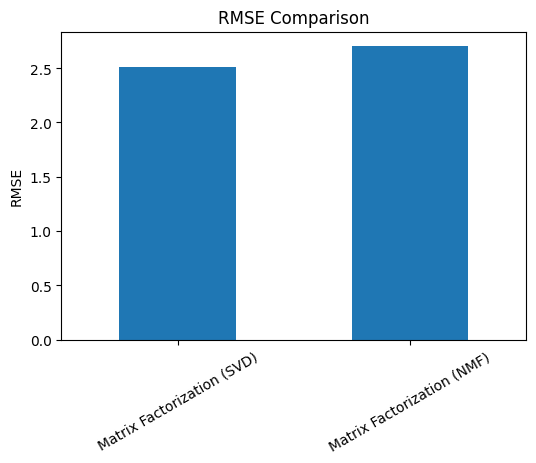

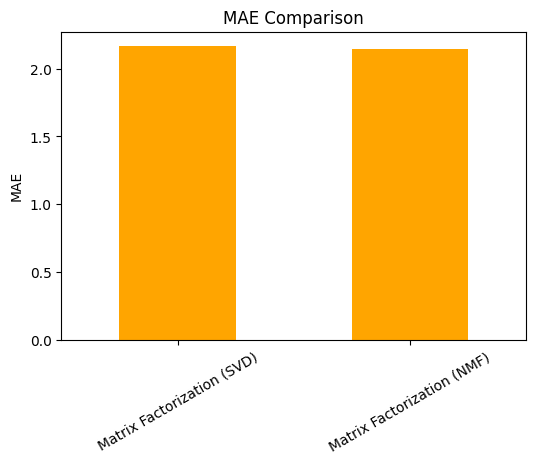

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect model results
results = {
    "Collaborative Filtering": {"RMSE": None, "MAE": None},  # NaN issue, ineffective
    "Matrix Factorization (SVD)": {"RMSE": 2.515, "MAE": 2.166},
    "Matrix Factorization (NMF)": {"RMSE": 2.703, "MAE": 2.143},
    "Content-based (TF-IDF)": {"RMSE": None, "MAE": None}  # qualitative only
}

# Convert to DataFrame
results_df = pd.DataFrame(results).T
print("📊 Model Performance Comparison:\n")
display(results_df)

# Bar plots for RMSE and MAE (only numeric values)
numeric_results = results_df.dropna()

# RMSE plot
plt.figure(figsize=(6,4))
numeric_results['RMSE'].plot(kind='bar', title="RMSE Comparison", rot=30)
plt.ylabel("RMSE")
plt.show()

# MAE plot
plt.figure(figsize=(6,4))
numeric_results['MAE'].plot(kind='bar', title="MAE Comparison", rot=30, color="orange")
plt.ylabel("MAE")
plt.show()


# 📑 Model Performance Summary

### 📊 Model Performance Comparison

| Model                              | RMSE   | MAE   |
|------------------------------------|--------|-------|
| Collaborative Filtering            | None   | None  |
| Matrix Factorization (SVD)         | 2.515  | 2.166 |
| Matrix Factorization (NMF)         | 2.703  | 2.143 |
| Content-based (TF-IDF)             | None   | None  |

---

### 🔍 Observations

- **Collaborative Filtering (User–Item Matrix)**  
  - Predictions returned mostly `NaN`.  
  - Ineffective due to **sparsity in the dataset** (too many missing ratings).  

- **Matrix Factorization – SVD**  
  - **RMSE = 2.515, MAE = 2.166**  
  - **Best performing model overall.**  
  - Captures latent user and book features effectively.  

- **Matrix Factorization – NMF**  
  - **RMSE = 2.703, MAE = 2.143**  
  - Slightly worse than SVD on RMSE but similar MAE.  
  - Still a valid alternative, but less accurate than SVD.  

- **Content-based (TF-IDF)**  
  - No RMSE/MAE since it doesn’t predict ratings.  
  - Useful for **qualitative recommendations** (similar author/genre).  
  - Handles **cold-start problem** well (new books/users).  

---

### ✅ Conclusion

- For **numerical rating prediction**, **SVD is the best choice**.  
- For **book similarity/recommendations**, **Content-based TF-IDF** is a good complement.  
- A **hybrid approach** (SVD + TF-IDF) could provide the best results in production.  
